<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/XAI_loan_prediction_LightGCM_Rana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries and Setup**

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.pipeline import Pipeline
import graphviz
from IPython.display import display
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import gc
import os
import pkg_resources
from sklearn import tree

<ipython-input-1-6a8db2625f81>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Set random seed
random_seed = 42
np.random.seed(random_seed)

In [ ]:
# Create o/p directory
os.makedirs('model_outputs', exist_ok=True)

 **Load and Prepare Data**

In [ ]:
print("\nLoading preprocessed data...")
df = pd.read_csv('final_loan_data_leakproof.csv')
print("Dataset shape:", df.shape)
print("Columns in dataset:", df.columns.tolist())


Loading preprocessed data...
Dataset shape: (50000, 31)
Columns in dataset: ['loan_amnt', 'installment', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'issue_d_year', 'issue_d_month', 'earliest_cr_line_year', 'earliest_cr_line_month', 'int_rate_grade', 'loan_to_income', 'dti_ratio', 'credit_history_years', 'income_bin', 'term_ 60 months', 'emp_length_10+ years', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_debt_consolidation', 'target']


In [ ]:
# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    le = LabelEncoder()
    for col in cat_cols:
        X[col] = le.fit_transform(X[col].astype(str))
    print(f"Encoded {len(cat_cols)} categorical columns.")

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Reset indices
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

Training set shape: (40000, 30)
Testing set shape: (10000, 30)


In [ ]:
# Apply SMOTE to balance training set
print("\nApplying SMOTE to balance training set...")
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced training set shape:", X_train_balanced.shape)
print("Class distribution after SMOTE:", y_train_balanced.value_counts().to_dict())


Applying SMOTE to balance training set...
Balanced training set shape: (63814, 30)
Class distribution after SMOTE: {0: 31907, 1: 31907}


In [ ]:
# Convert to numpy arrays
X_test_np = X_test.values
X_train_np = X_train_balanced.values
y_train_np = y_train_balanced.values

**Model Building and Training**

In [ ]:
# Create pipeline with scaler and LightGBM classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(random_state=random_seed))
])

In [ ]:
# Expanded parameter grid for GridSearchCV
param_grid = {
'model__num_leaves': [31],
    'model__learning_rate': [0.05],
    'model__n_estimators': [100, 200]
}

In [ ]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 31907, number of negative: 31907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5885
[LightGBM] [Info] Number of data points in the train set: 63814, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05],
                         'model__n_estimators': [100, 200],
                         'model__num_leaves': [31]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Best model
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['model']
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

# Save model
with open('model_outputs/lightgbm_pipeline.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)
print("Pipeline saved as 'model_outputs/lightgbm_pipeline.pkl'")

Best parameters: {'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 31}
Best ROC-AUC score: 0.9255921334796879
Pipeline saved as 'model_outputs/lightgbm_pipeline.pkl'


**Observation:**
 - The LightGBM model, optimized via GridSearchCV, achieved a strong ROC-AUC score of 0.926 with the best parameters: learning rate of 0.05, 100 estimators, 31 leaves.

**Model Evaluation**

In [ ]:
# Predict probabilities and adjust threshold
threshold = 0.5
y_pred_proba = best_pipeline.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

In [ ]:
# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

In [ ]:
# Print metrics
print("\nModel Performance Metrics (threshold = 0.5):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance Metrics (threshold = 0.5):
Accuracy: 0.8018
Precision: 0.5480
Recall: 0.1157
F1-Score: 0.1910
ROC-AUC: 0.7169


**Observation:**
- The LightGBM model, evaluated with a 0.5 threshold, shows moderate accuracy (0.8018) but low precision (0.5480), recall (0.1157), and F1-score (0.1910), indicating poor performance in identifying positive cases (loan defaults).
- Despite a decent ROC-AUC (0.7169), the low recall suggests the model struggles to capture true positives, likely due to class imbalance or threshold sensitivity.

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      7977
           1       0.55      0.12      0.19      2023

    accuracy                           0.80     10000
   macro avg       0.68      0.55      0.54     10000
weighted avg       0.76      0.80      0.75     10000



<Figure size 800x600 with 0 Axes>

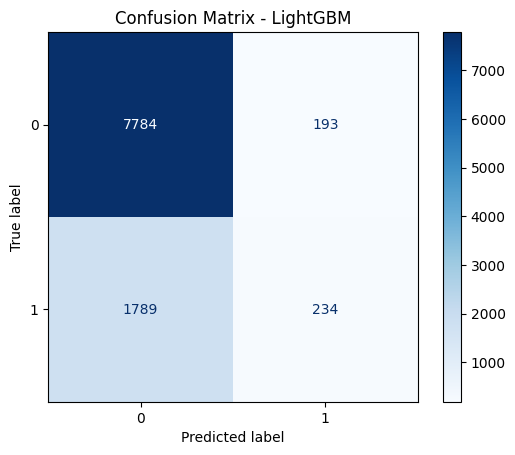

Confusion matrix saved as 'model_outputs/confusion_matrix.png'


In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.savefig('model_outputs/confusion_matrix.png')
plt.show()
plt.close()
print("Confusion matrix saved as 'model_outputs/confusion_matrix.png'")

**Observation:**
- confusion matrix for the LightGBM model reveals a significant class imbalance, with 7,784 true negatives (0,0) and 1,789 false negatives (1,0), compared to 193 false positives (0,1) and 243 true positives (1,1).

In [ ]:
# Save metrics
with open('model_outputs/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")
print("Evaluation metrics saved as 'model_outputs/evaluation_metrics.txt'")

Evaluation metrics saved as 'model_outputs/evaluation_metrics.txt'


**Explainability Techniques**

SHAP Values

Computing SHAP values...


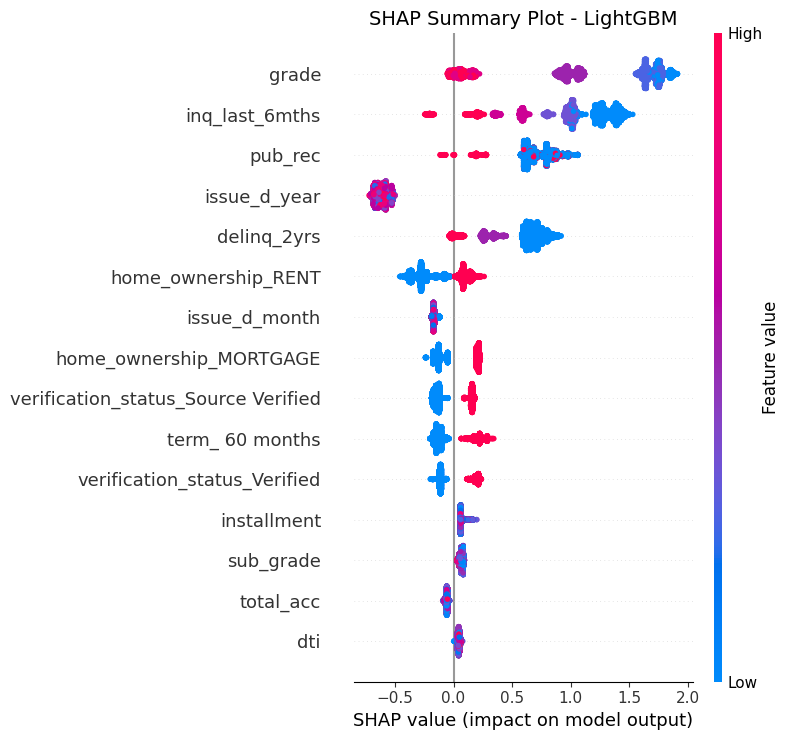

SHAP summary plot saved as 'model_outputs/shap_summary.png'


In [ ]:
# 4.1 SHAP Values
print("Computing SHAP values...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_np)

# Handle binary classification SHAP output
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# SHAP Beeswarm Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=15, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - LightGBM", fontsize=14)
plt.tight_layout()
plt.savefig('model_outputs/shap_summary.png')
plt.show()
plt.close()
print("SHAP summary plot saved as 'model_outputs/shap_summary.png'")

**Observation:**
- The SHAP summary plot for the LightGBM model shows that the most impactful feature on the model's output is grade, followed by inq_last_6mths and delinq_2yrs.
- High values of grade (in pink) increase the model prediction, while high values of home_ownership_RENT and term_ 60 months also contribute positively.
- Conversely, high values of dti and total_acc have relatively low or slightly negative impacts.

Permutation Feature Importance

Computing Permutation Feature Importance...


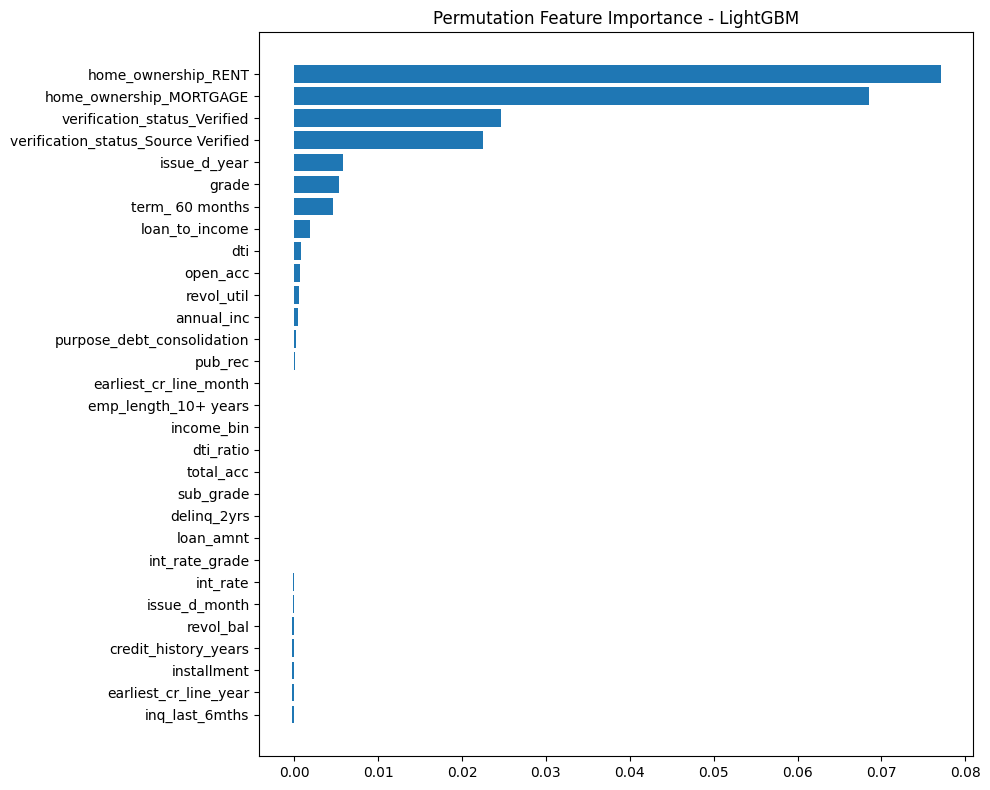

Permutation importance plot saved as 'model_outputs/permutation_importance.png'


In [ ]:
# 4.2 Permutation Feature Importance
print("Computing Permutation Feature Importance...")
perm_importance = permutation_importance(best_pipeline, X_test_np, y_test, n_repeats=10, random_state=random_seed)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Feature Importance - LightGBM')
plt.tight_layout()
plt.savefig('model_outputs/permutation_importance.png')
plt.show()
plt.close()
print("Permutation importance plot saved as 'model_outputs/permutation_importance.png'")

**Observation:**
- The permutation feature importance plot shows that home_ownership_RENT, home_ownership_MORTGAGE, and verification_status_Verified are the top contributors to model performance, while many other features have minimal impact.

Global Surrogate Model

Building Global Surrogate Model with Decision Tree...
Surrogate Model R^2 Score: 0.7642


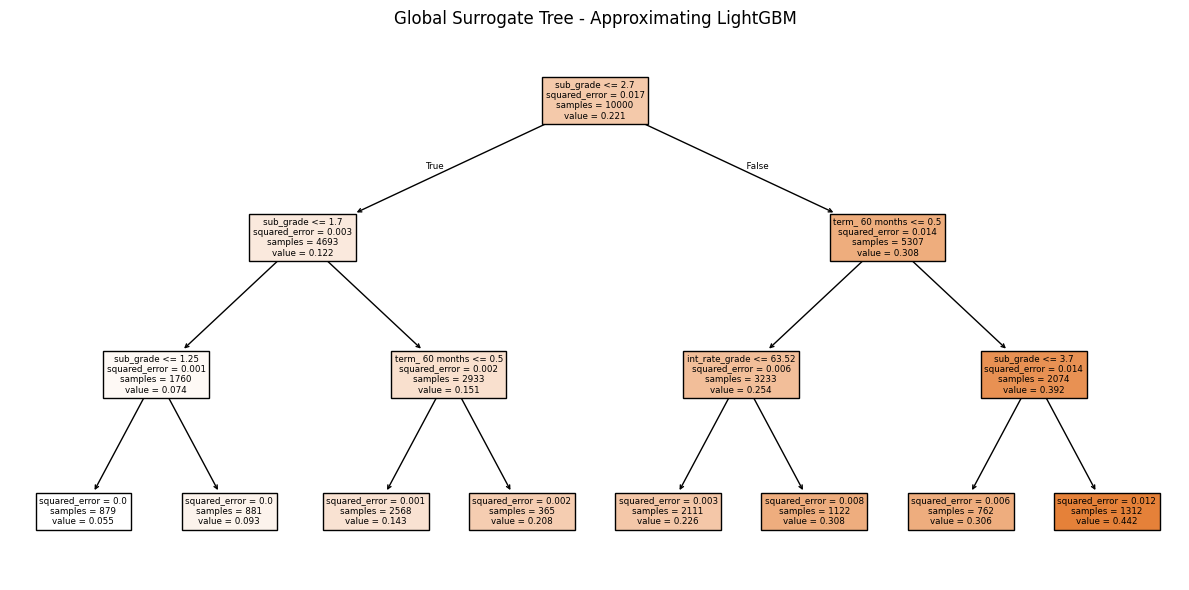

Surrogate decision tree visualization saved as 'model_outputs/surrogate_decision_tree.png'


In [ ]:
# 4.3 Global Surrogate Model
# Build and fit global surrogate model
print("Building Global Surrogate Model with Decision Tree...")
y_pred_proba_surrogate = best_pipeline.predict_proba(X_test_np)[:, 1]
surrogate = DecisionTreeRegressor(max_depth=3, random_state=random_seed)
surrogate.fit(X_test, y_pred_proba_surrogate)

# Evaluate surrogate model
surrogate_r2 = surrogate.score(X_test, y_pred_proba_surrogate)
print(f"Surrogate Model R^2 Score: {surrogate_r2:.4f}")

# Plot the surrogate tree
plt.figure(figsize=(12, 6))
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating LightGBM")
plt.tight_layout()
plt.savefig('model_outputs/surrogate_decision_tree.png')
plt.show()
plt.close()
print("Surrogate decision tree visualization saved as 'model_outputs/surrogate_decision_tree.png'")

**Observation:**
- The global surrogate tree shows that sub_grade, int_rate_grade, term_60 months, and grade are key decision points approximating the LightGBM model, with lower interest rates and better sub-grades associated with lower predicted values.

Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE)

Generating PDP and ICE for top features...
Top features for PDP/ICE: ['pub_rec', 'inq_last_6mths', 'grade']


<Figure size 1500x500 with 0 Axes>

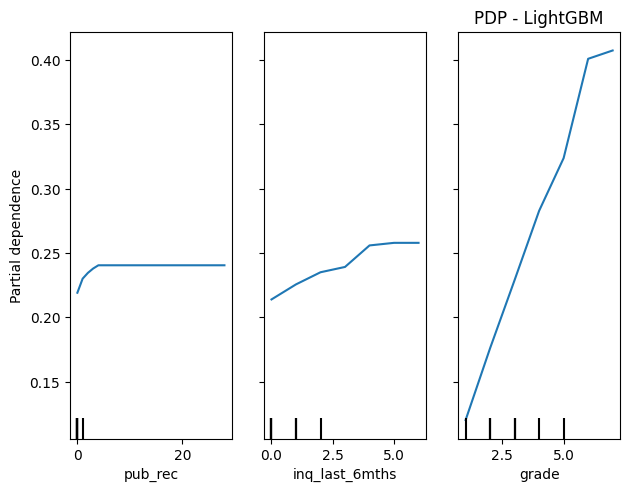

PDP plots saved as 'model_outputs/pdp_plots.png'


<Figure size 1500x500 with 0 Axes>

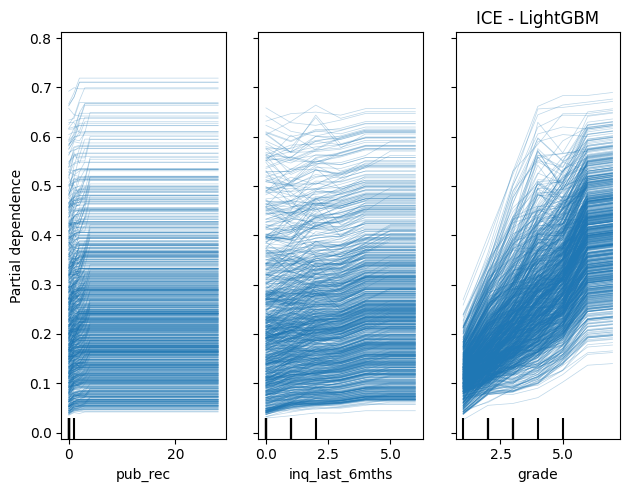

ICE plots saved as 'model_outputs/ice_plots.png'


In [ ]:
# Generate PDP and ICE for top features
print("Generating PDP and ICE for top features...")
shap_importance = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_importance)[-3:]
top_features = [X.columns[i] for i in top_indices]
print(f"Top features for PDP/ICE: {top_features}")

# PDP
plt.figure(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline,
    X_test,
    features=top_indices,
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.title("PDP - LightGBM")
plt.savefig('model_outputs/pdp_plots.png')
plt.show()
plt.close()
print("PDP plots saved as 'model_outputs/pdp_plots.png'")

# ICE
plt.figure(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline,
    X_test,
    features=top_indices,
    kind='individual',
    grid_resolution=20
)
plt.tight_layout()
plt.title("ICE - LightGBM")
plt.savefig('model_outputs/ice_plots.png')
plt.show()
plt.close()
print("ICE plots saved as 'model_outputs/ice_plots.png'")

**Observation:**
- The PDP plot for the LightGBM model shows that delinq_2yrs has minimal impact on predictions, inq_last_6mths has a moderate increasing effect, and grade has a strong positive influence on the predicted probability of loan default.

**Observation:**
- The ICE-LightGBM model shows that higher partial dependence on grade, with less influence from delinquency in the last 2 years and inquiries in the last 6 months, indicates a stronger relationship with the target variable.